# Estimate Functional Connectivity

In [1]:
## load packages
from copy import deepcopy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy import stats
from sklearn.covariance import GraphicalLassoCV
import seaborn as sns
import sys

from FC_est import *

seed = 888;
np.random.seed(seed) # fix randomness

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/caratan/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/caratan/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Load deconvolved data

In [2]:
## load deconvolved data
deconv = sio.loadmat("../data/sample_deconv_traces.mat");
Y_real = (deconv["s"]/deconv["sn"]).T; # normalize it by noise level (important!)
Y_const = Y_real

# Functional Connectivity under Different Transformation Methods
We first apply various data transformation methods to make the marginal distribution of each neuron's activity Gaussian. Note that since Bernoulli distribution fails to show a good approximation in distribution in the encoding model in the ZIG paper, we will not consider relevant transformation for Bernoulli data.  

We then apply Gaussian graphical model to estimate the functional connectivity on the transformed dataset.

Finally, we compare the estimated connectivity graph with the one if Gaussianity is assumed from the very beginning (only normlization).


### Resources:
Anscombe Transformation: https://github.com/broxtronix/pymultiscale/blob/master/pymultiscale/anscombe.py

Box-cox Transformation: https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution  
Yeo-Johnson Transformation: https://www.stat.umn.edu/arc/yjpower.pdf


ZIG -> Normal: Since ZIG is composed of a dirac delta(0) and a weighted gamma distribution, there is by far no closed form solution for this type of distribution. We take a data-driven approach and use quantile transformation in this case.

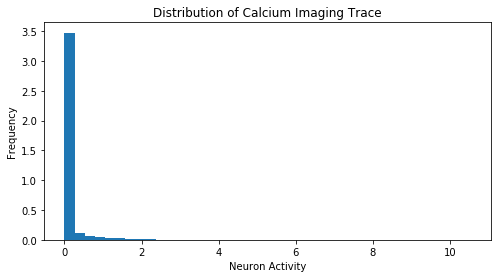

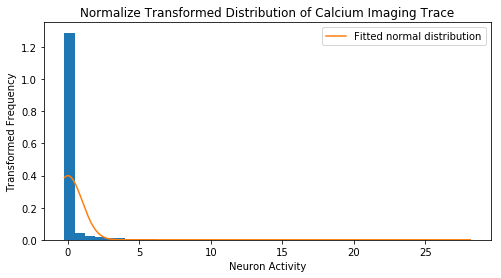

In [3]:
# Normalize
nid = 40
plot_original(Y_const[:, nid])

norm_y = ss.fit_transform(Y_const)
plot_transformed(norm_y[:, nid], method="Normalize")

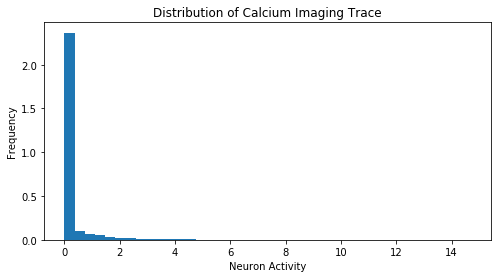

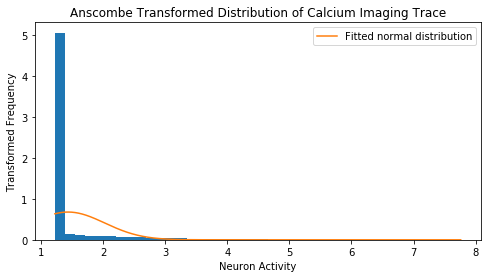

In [4]:
# Poisson -- Anscombe transformation
nid = 1
plot_original(Y_const[:, nid])

poisson_y = anscombe(Y_const)
plot_transformed(poisson_y[:, nid], method="Anscombe")


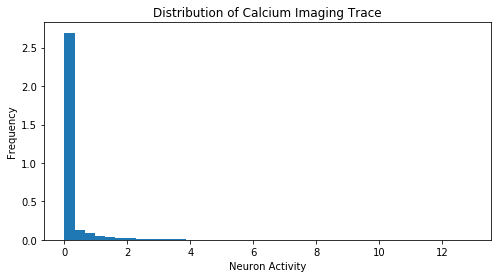

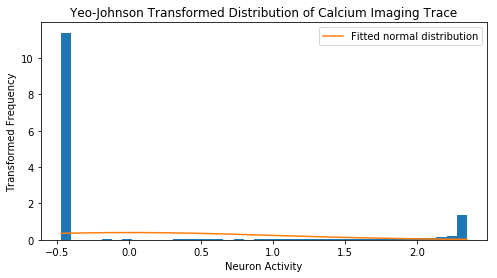

In [5]:
# Gamma -- Power transformation
nid = 15
plot_original(Y_const[:, nid])

gamma_y = yj.fit_transform(Y_const)
plot_transformed(gamma_y[:, nid], method="Yeo-Johnson")

#gamma_y_log = log_trans(Y_const)
#plot_transformed(gamma_y_log[:, 15], method="Log")

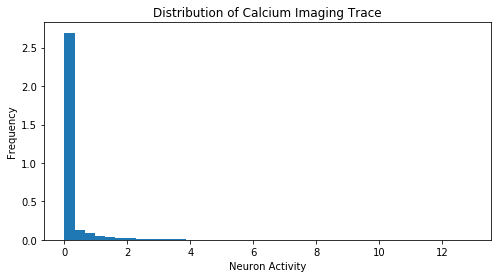

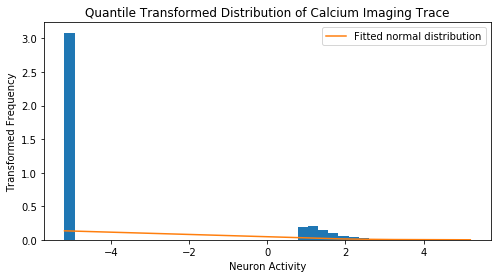

In [6]:
# Zig
nid = 15
plot_original(Y_const[:, nid])

zig_y = qt.fit_transform(Y_const)
plot_transformed(zig_y[:, nid], method="Quantile")

## Test Normality
Given the p-values computed below, none of the transformation techniques successfully transformed the data to Gaussian distribution.

In [7]:
alpha = 0.05
pvals = []
for i in range(45):
    k, p = stats.normaltest(poisson_y[:, i])
    pvals.append(p)

pvals = np.array(pvals)
print(pvals)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Apply Graphical Models

In [8]:
# Apply graphical Lasso
norm_cov, norm_prec, norm_alpha = est_connectivity(norm_y) # Assume normality

anscombe_cov, anscombe_prec, anscombe_alpha = est_connectivity(poisson_y)

yj_cov, yj_prec, yj_alpha = est_connectivity(gamma_y)

qt_cov, qt_prec, qt_alpha = est_connectivity(zig_y)

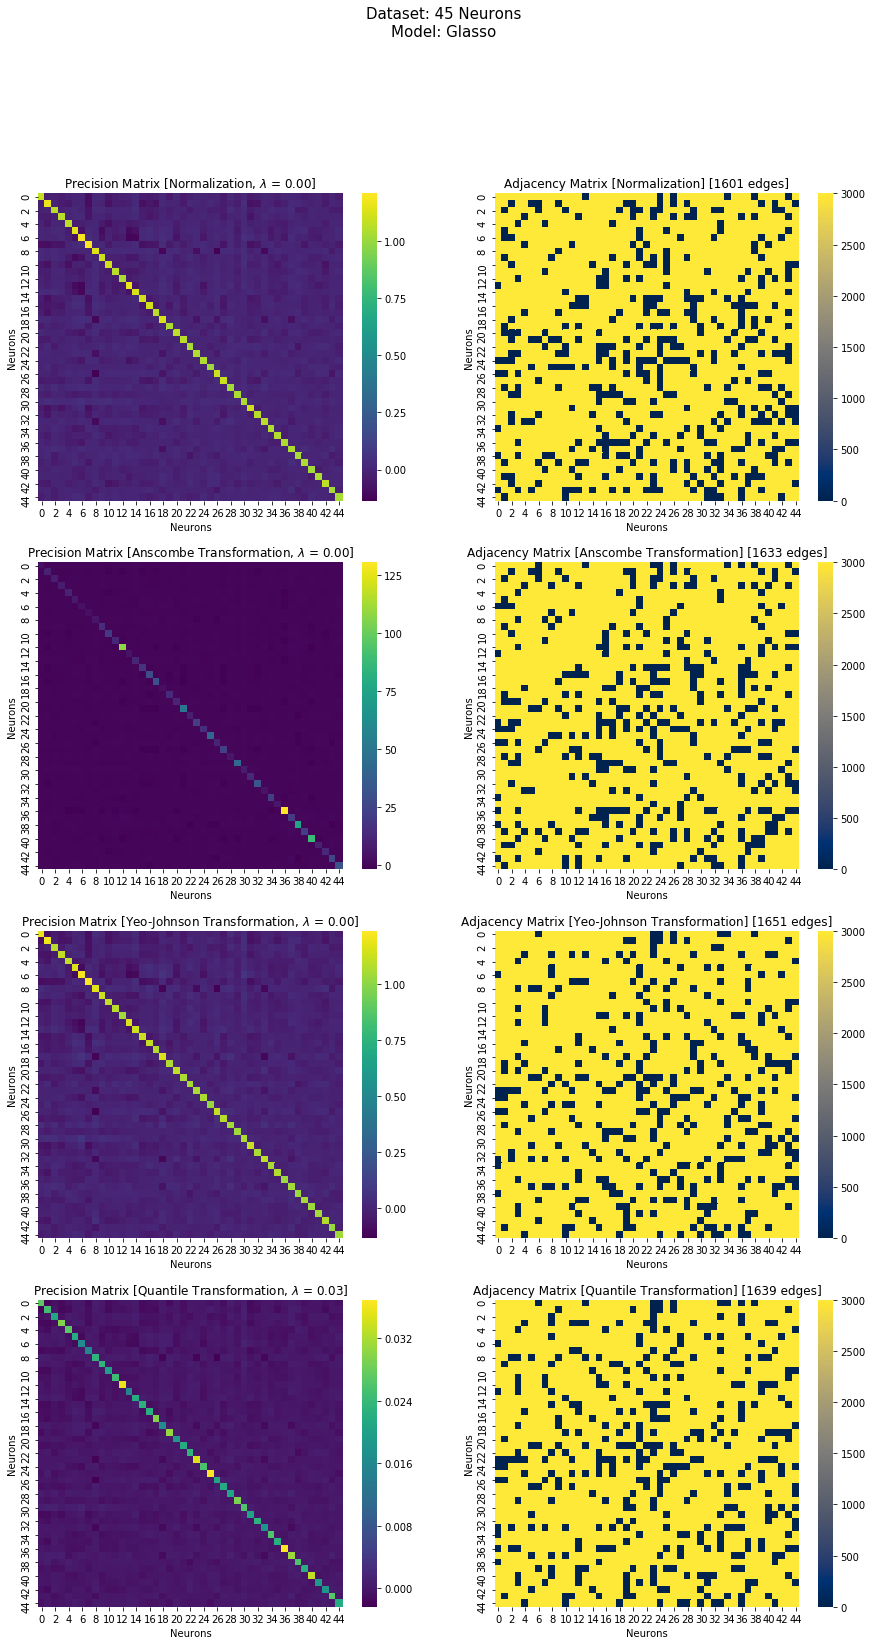

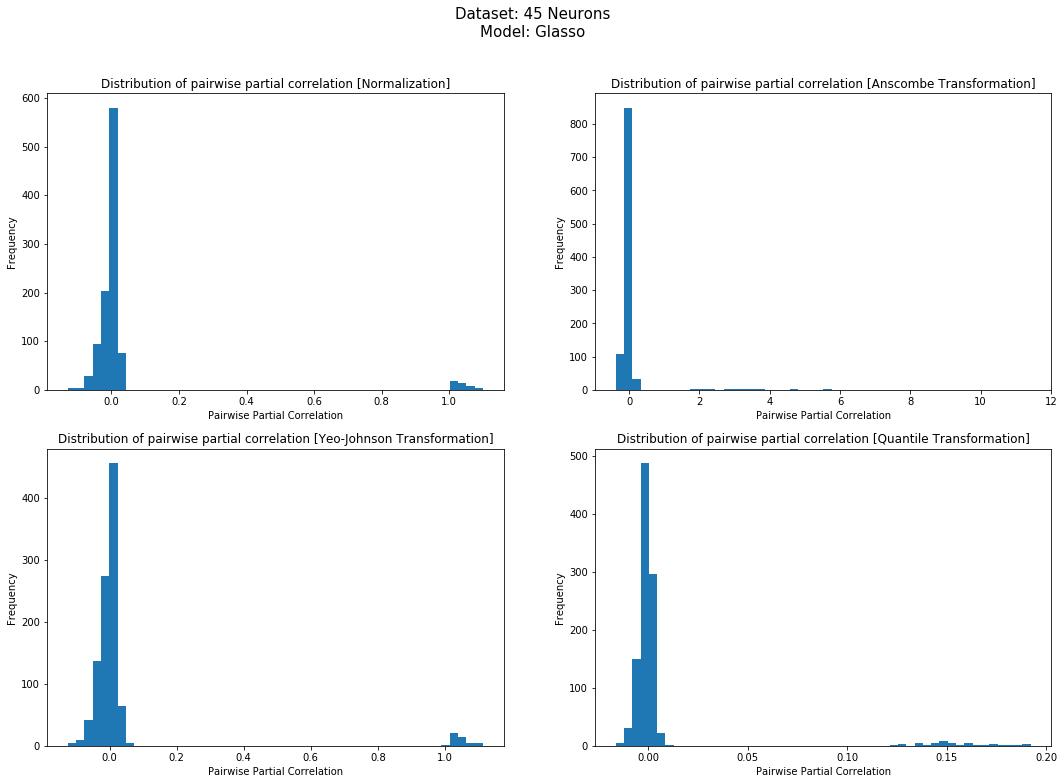

Matching percentage between Normalization and Anscombe transformation: 0.91
Overlap edge percentage wrt Normalization: 0.96
Overlap edge percentage wrt Anscombe transformation: 0.94

Matching percentage between Normalization and Yeo-Johnson transformation: 0.80
Overlap edge percentage wrt Normalization: 0.89
Overlap edge percentage wrt Yeo-Johnson transformation: 0.86

Matching percentage between Normalization and Quantile transformation: 0.78
Overlap edge percentage wrt Normalization: 0.88
Overlap edge percentage wrt Quantile transformation: 0.85

Matching percentage between Anscombe transformation and Yeo-Johnson transformation: 0.84
Overlap edge percentage wrt Anscombe transformation: 0.91
Overlap edge percentage wrt Yeo-Johnson transformation: 0.90

Matching percentage between Anscombe transformation and Quantile transformation: 0.82
Overlap edge percentage wrt Anscombe transformation: 0.89
Overlap edge percentage wrt Quantile transformation: 0.88

Matching percentage between Yeo-J

In [9]:
# Plot everything
norm_A, anscombe_A, yj_A, qt_A = compare_diff_trans(norm_prec, anscombe_prec, yj_prec, qt_prec,
                                                    norm_alpha, anscombe_alpha, yj_alpha, qt_alpha,
                                                    dataset="45 Neurons", gm="Glasso")


## Load Stringer Datasets

We conduct the above analysis on the neuron plane with the least depth for each neuron activity recording published by Stringer et. al.


In [10]:
# fsp shape: (neurons, timepoints)
spont_fp = "../data/stringer_spont_170818.mat"
fsp_spont = sio.loadmat(spont_fp).get("Fsp")
print(fsp_spont.shape)

stimspont_fp = "../data/stringer_stimspont_170825.mat"
fsp_stim = sio.loadmat(stimspont_fp).get("Fsp")
print(fsp_stim.shape)

ori_fp = "../data/stringer_ori32_170817.mat"
fsp_ori = sio.loadmat(ori_fp).get("Fsp")
print(fsp_ori.shape)

(10640, 10463)
(11591, 16524)
(10999, 18781)


In [11]:
START_TPT = 100
END_TPT = 5100
TPT_STEP = 5
TPTS = range(START_TPT, END_TPT, TPT_STEP)

NID_MIN = 0
NID_MAX = 100

## Quic Glasso CV

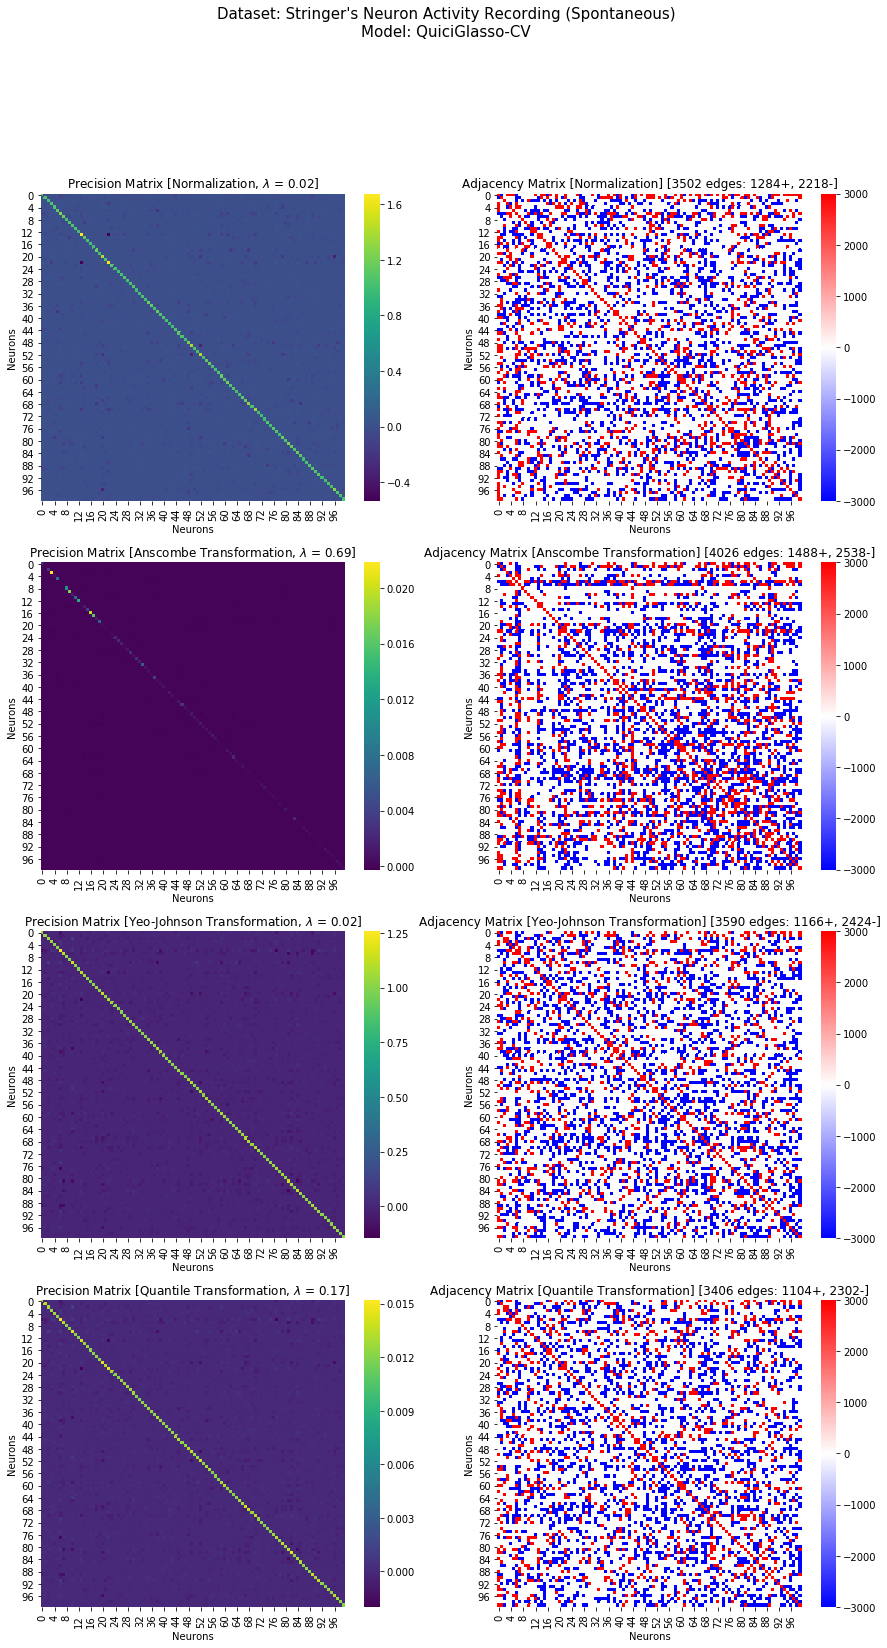

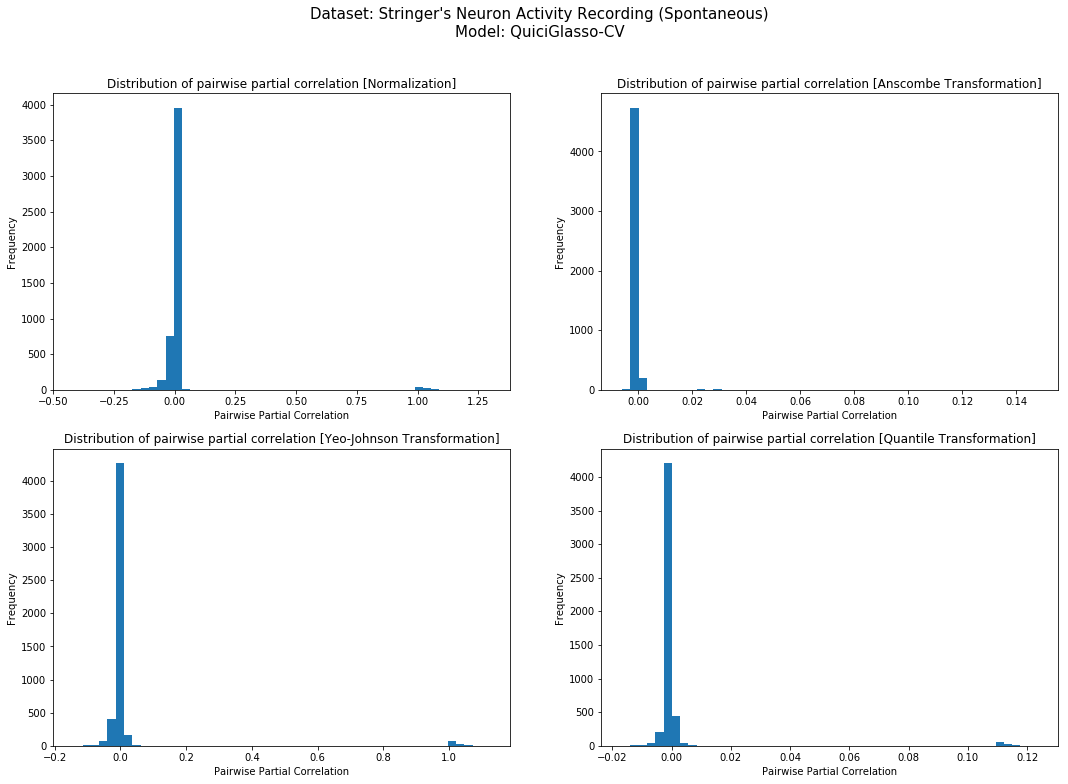

Matching percentage between Normalization and Anscombe transformation: 0.78
Overlap positive edge percentage wrt Normalization: 0.73
Overlap positive edge percentage wrt Anscombe transformation: 0.63

Overlap negative edge percentage wrt Normalization: 0.77
Overlap negative edge percentage wrt Anscombe transformation: 0.67

Matching percentage between Normalization and Yeo-Johnson transformation: 0.69
Overlap positive edge percentage wrt Normalization: 0.44
Overlap positive edge percentage wrt Yeo-Johnson transformation: 0.49

Overlap negative edge percentage wrt Normalization: 0.62
Overlap negative edge percentage wrt Yeo-Johnson transformation: 0.57

Matching percentage between Normalization and Quantile transformation: 0.69
Overlap positive edge percentage wrt Normalization: 0.43
Overlap positive edge percentage wrt Quantile transformation: 0.51

Overlap negative edge percentage wrt Normalization: 0.60
Overlap negative edge percentage wrt Quantile transformation: 0.58

Matching perc

In [12]:
# Spontaneous activity dataset
spont_x = fsp_spont[:100, START_TPT:END_TPT].T
spont_outs_quic = run_all(spont_x, gm="QuiciGlasso-CV",
                          dataset="Stringer's Neuron Activity Recording (Spontaneous)", 
                          include_negs=True)


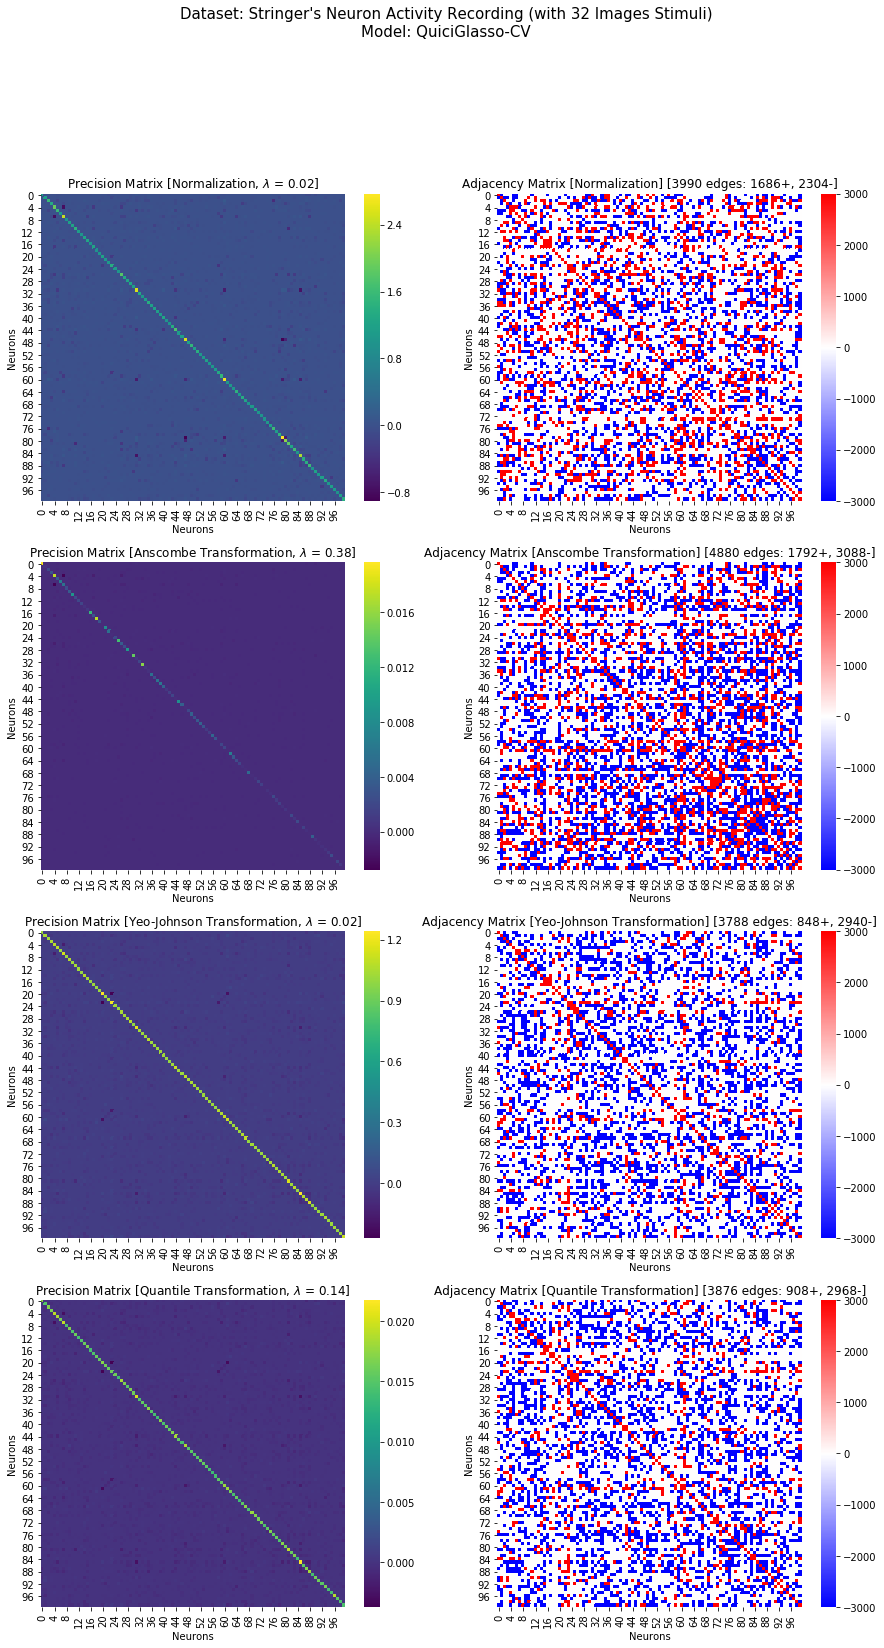

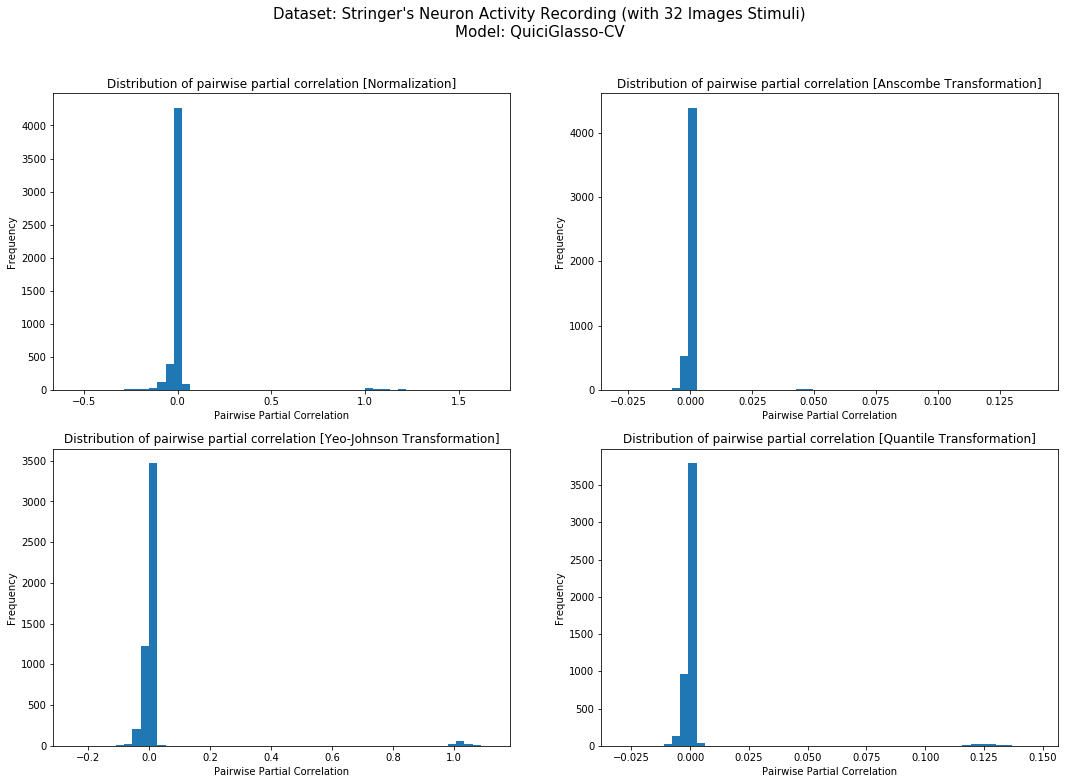

Matching percentage between Normalization and Anscombe transformation: 0.76
Overlap positive edge percentage wrt Normalization: 0.72
Overlap positive edge percentage wrt Anscombe transformation: 0.68

Overlap negative edge percentage wrt Normalization: 0.87
Overlap negative edge percentage wrt Anscombe transformation: 0.65

Matching percentage between Normalization and Yeo-Johnson transformation: 0.61
Overlap positive edge percentage wrt Normalization: 0.23
Overlap positive edge percentage wrt Yeo-Johnson transformation: 0.50

Overlap negative edge percentage wrt Normalization: 0.64
Overlap negative edge percentage wrt Yeo-Johnson transformation: 0.51

Matching percentage between Normalization and Quantile transformation: 0.62
Overlap positive edge percentage wrt Normalization: 0.26
Overlap positive edge percentage wrt Quantile transformation: 0.52

Overlap negative edge percentage wrt Normalization: 0.67
Overlap negative edge percentage wrt Quantile transformation: 0.52

Matching perc

In [13]:
stim_x = fsp_stim[:100, START_TPT:END_TPT].T
stim_outs_quic = run_all(stim_x, gm="QuiciGlasso-CV",
                         dataset="Stringer's Neuron Activity Recording (with 32 Images Stimuli)", 
                         include_negs=True)


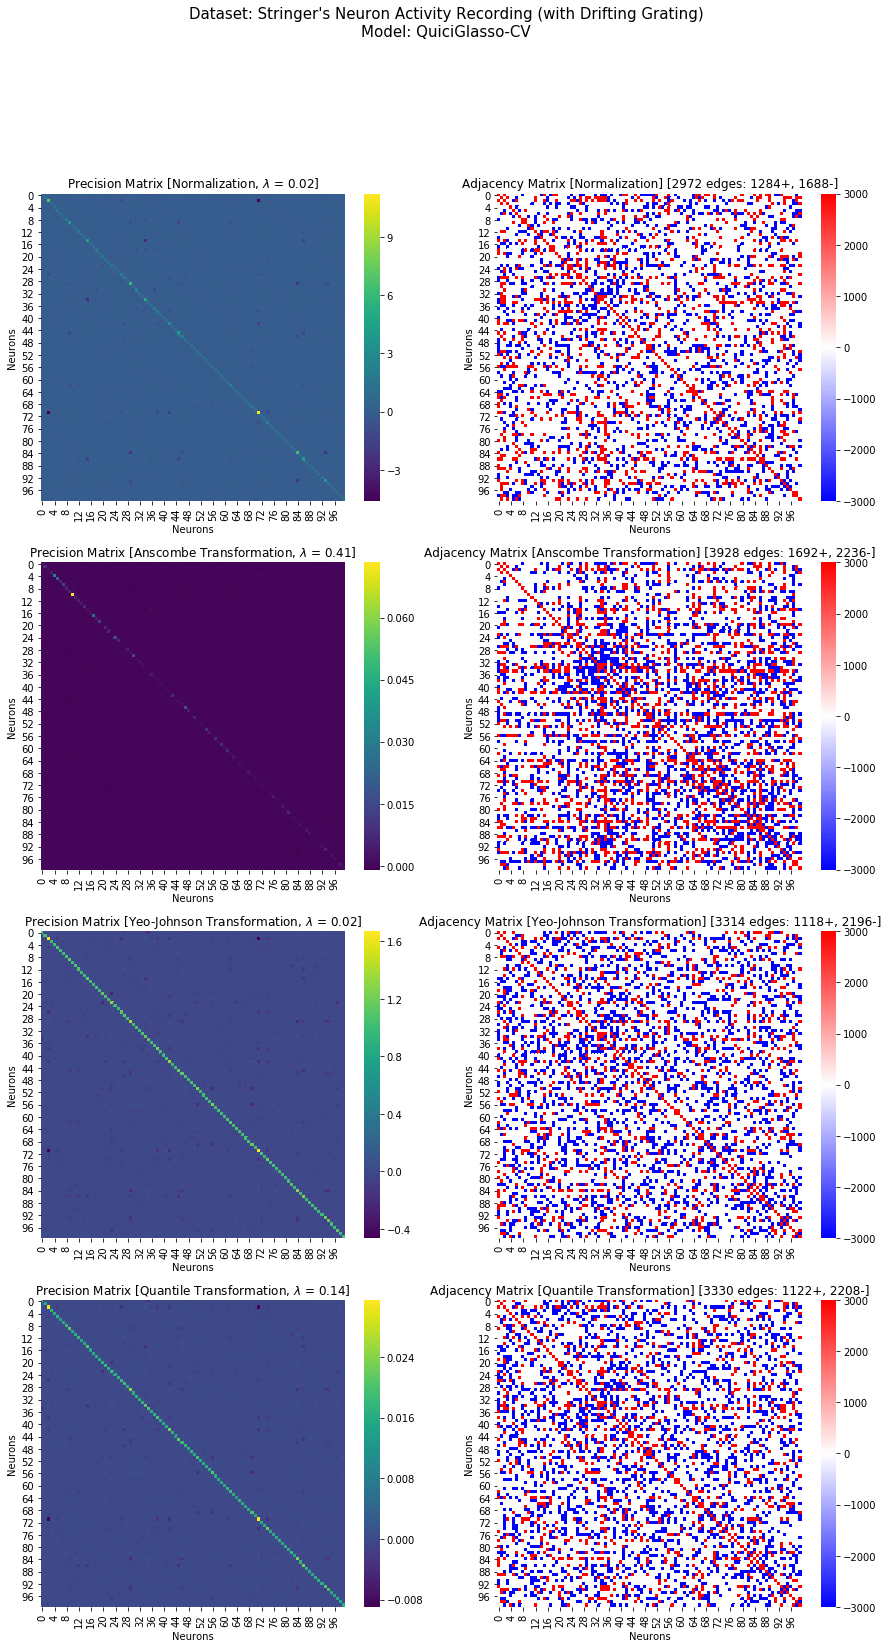

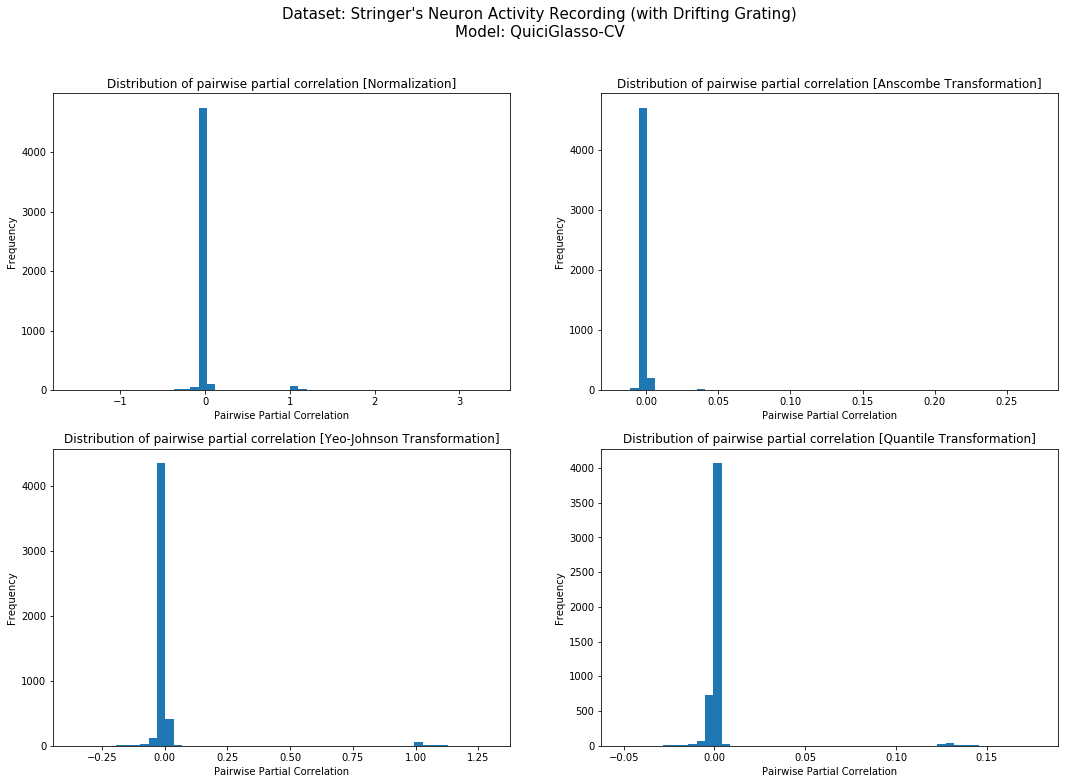

Matching percentage between Normalization and Anscombe transformation: 0.77
Overlap positive edge percentage wrt Normalization: 0.78
Overlap positive edge percentage wrt Anscombe transformation: 0.58

Overlap negative edge percentage wrt Normalization: 0.78
Overlap negative edge percentage wrt Anscombe transformation: 0.59

Matching percentage between Normalization and Yeo-Johnson transformation: 0.68
Overlap positive edge percentage wrt Normalization: 0.37
Overlap positive edge percentage wrt Yeo-Johnson transformation: 0.43

Overlap negative edge percentage wrt Normalization: 0.60
Overlap negative edge percentage wrt Yeo-Johnson transformation: 0.46

Matching percentage between Normalization and Quantile transformation: 0.69
Overlap positive edge percentage wrt Normalization: 0.39
Overlap positive edge percentage wrt Quantile transformation: 0.45

Overlap negative edge percentage wrt Normalization: 0.61
Overlap negative edge percentage wrt Quantile transformation: 0.47

Matching perc

In [14]:
ori_x = fsp_ori[:100, START_TPT:END_TPT].T
ori_outs_quic = run_all(ori_x, gm="QuiciGlasso-CV",
                        dataset="Stringer's Neuron Activity Recording (with Drifting Grating)",
                        include_negs=True)


## Quic Glasso BIC

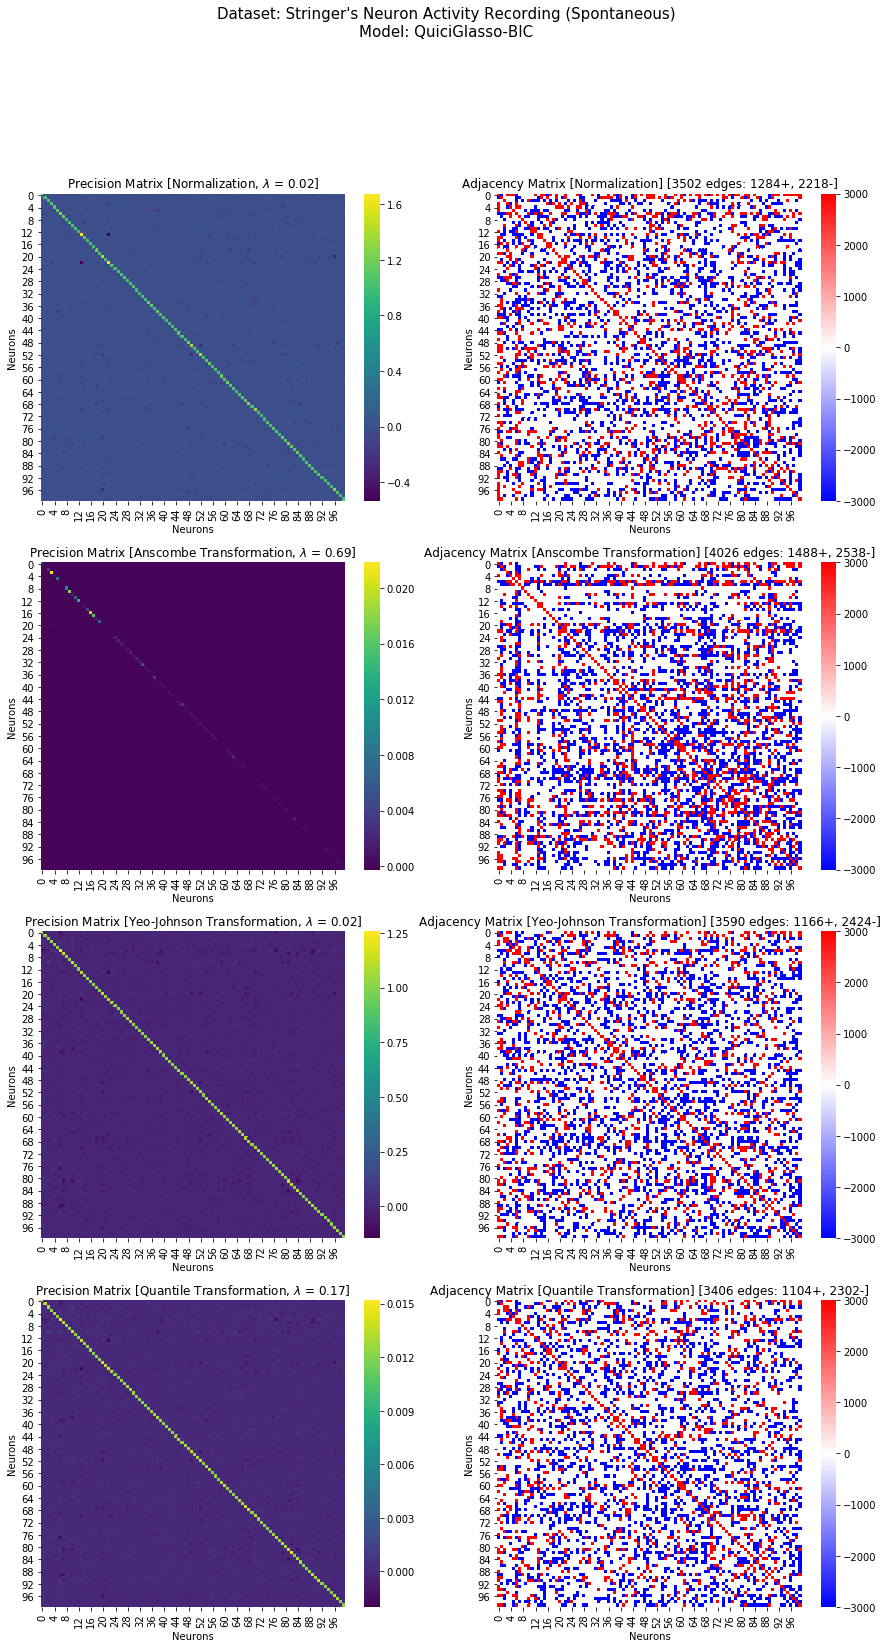

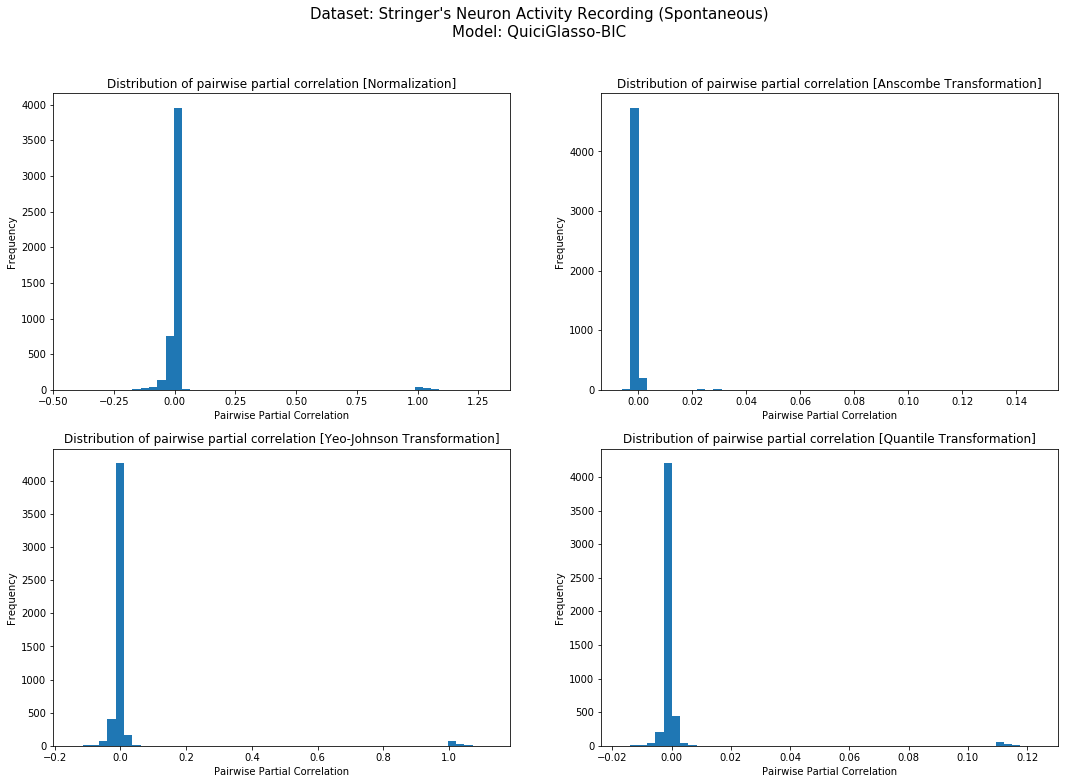

Matching percentage between Normalization and Anscombe transformation: 0.78
Overlap positive edge percentage wrt Normalization: 0.73
Overlap positive edge percentage wrt Anscombe transformation: 0.63

Overlap negative edge percentage wrt Normalization: 0.77
Overlap negative edge percentage wrt Anscombe transformation: 0.67

Matching percentage between Normalization and Yeo-Johnson transformation: 0.69
Overlap positive edge percentage wrt Normalization: 0.44
Overlap positive edge percentage wrt Yeo-Johnson transformation: 0.49

Overlap negative edge percentage wrt Normalization: 0.62
Overlap negative edge percentage wrt Yeo-Johnson transformation: 0.57

Matching percentage between Normalization and Quantile transformation: 0.69
Overlap positive edge percentage wrt Normalization: 0.43
Overlap positive edge percentage wrt Quantile transformation: 0.51

Overlap negative edge percentage wrt Normalization: 0.60
Overlap negative edge percentage wrt Quantile transformation: 0.58

Matching perc

In [15]:
spont_outs_qbic = run_all(spont_x, dataset="Stringer's Neuron Activity Recording (Spontaneous)", 
                          gm="QuiciGlasso-BIC", include_negs=True)


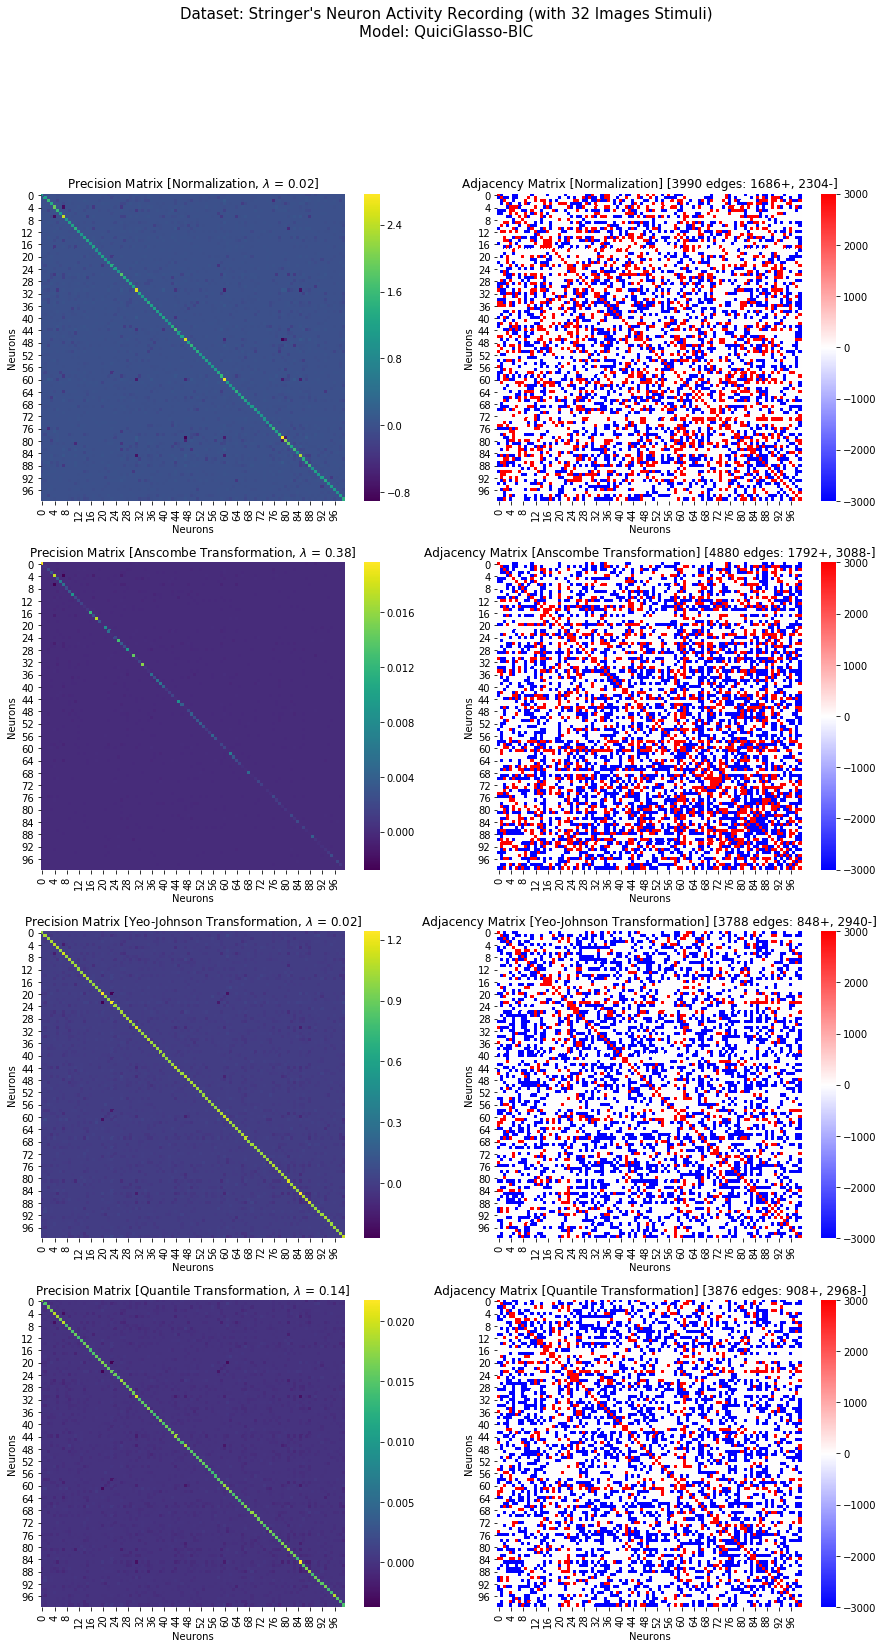

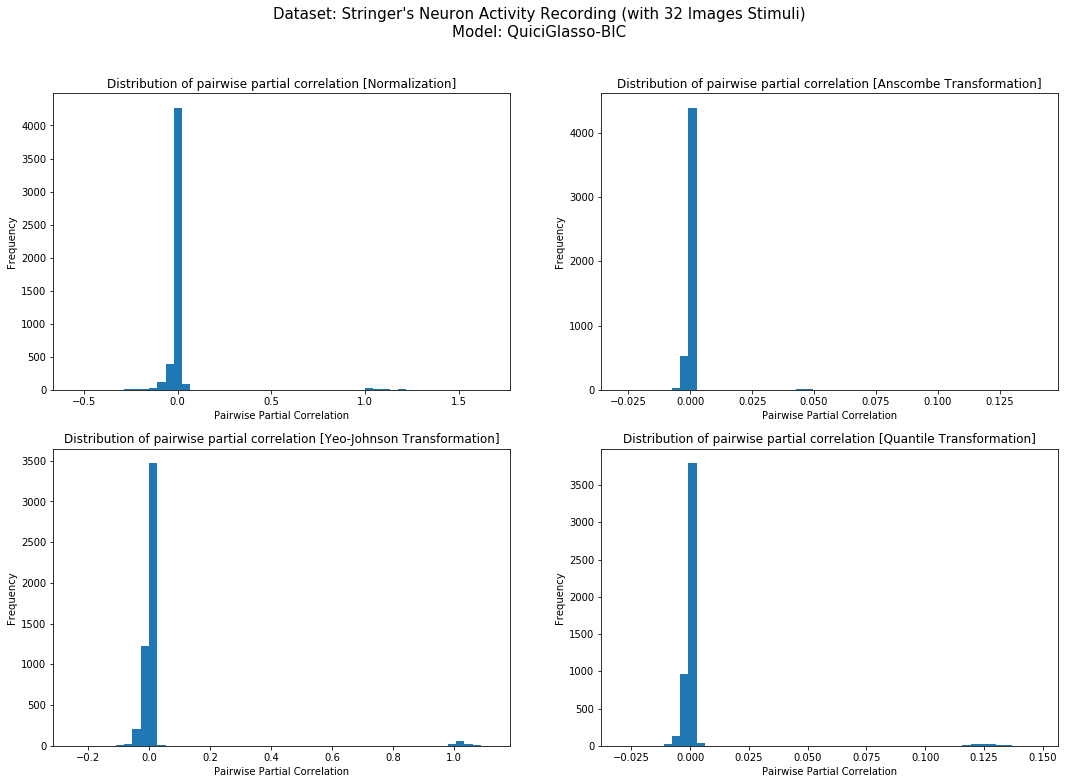

Matching percentage between Normalization and Anscombe transformation: 0.76
Overlap positive edge percentage wrt Normalization: 0.72
Overlap positive edge percentage wrt Anscombe transformation: 0.68

Overlap negative edge percentage wrt Normalization: 0.87
Overlap negative edge percentage wrt Anscombe transformation: 0.65

Matching percentage between Normalization and Yeo-Johnson transformation: 0.61
Overlap positive edge percentage wrt Normalization: 0.23
Overlap positive edge percentage wrt Yeo-Johnson transformation: 0.50

Overlap negative edge percentage wrt Normalization: 0.64
Overlap negative edge percentage wrt Yeo-Johnson transformation: 0.51

Matching percentage between Normalization and Quantile transformation: 0.62
Overlap positive edge percentage wrt Normalization: 0.26
Overlap positive edge percentage wrt Quantile transformation: 0.52

Overlap negative edge percentage wrt Normalization: 0.67
Overlap negative edge percentage wrt Quantile transformation: 0.52

Matching perc

In [16]:
stim_x = fsp_stim[:100, START_TPT:END_TPT].T
stim_outs_qbic = run_all(stim_x, dataset="Stringer's Neuron Activity Recording (with 32 Images Stimuli)", 
                         gm="QuiciGlasso-BIC",include_negs=True)


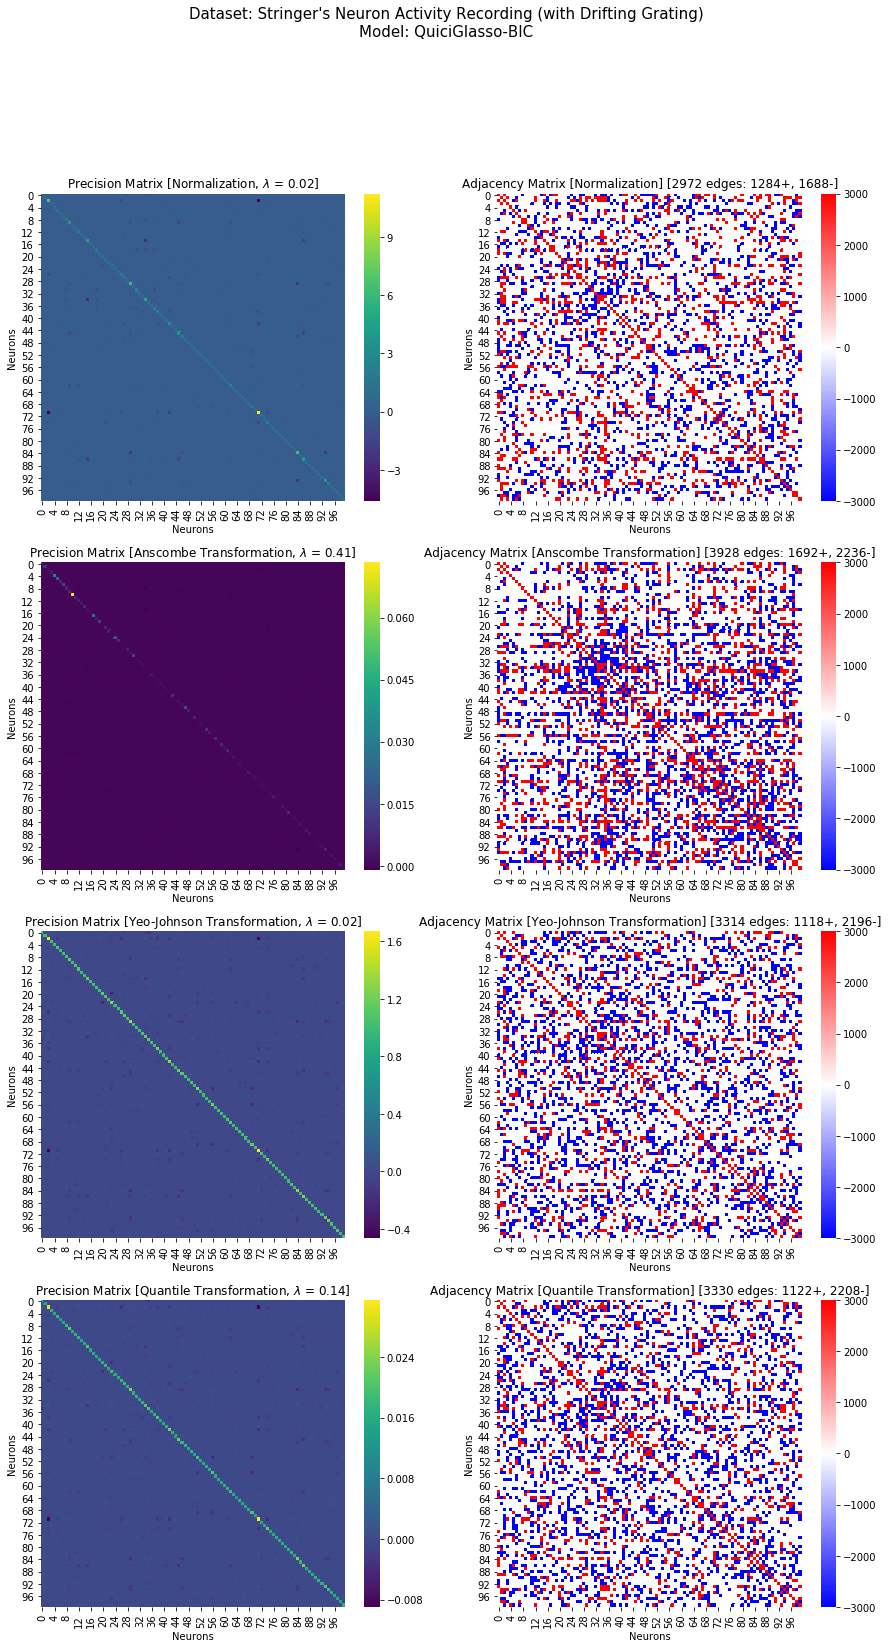

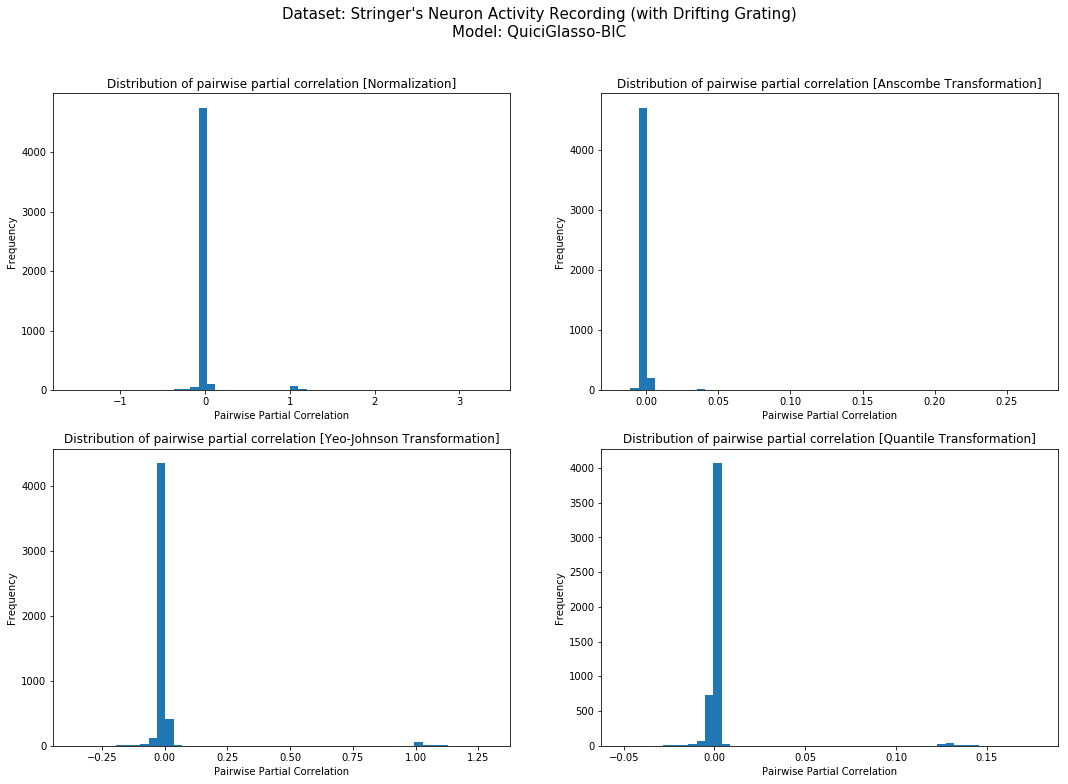

Matching percentage between Normalization and Anscombe transformation: 0.77
Overlap positive edge percentage wrt Normalization: 0.78
Overlap positive edge percentage wrt Anscombe transformation: 0.58

Overlap negative edge percentage wrt Normalization: 0.78
Overlap negative edge percentage wrt Anscombe transformation: 0.59

Matching percentage between Normalization and Yeo-Johnson transformation: 0.68
Overlap positive edge percentage wrt Normalization: 0.37
Overlap positive edge percentage wrt Yeo-Johnson transformation: 0.43

Overlap negative edge percentage wrt Normalization: 0.60
Overlap negative edge percentage wrt Yeo-Johnson transformation: 0.46

Matching percentage between Normalization and Quantile transformation: 0.69
Overlap positive edge percentage wrt Normalization: 0.39
Overlap positive edge percentage wrt Quantile transformation: 0.45

Overlap negative edge percentage wrt Normalization: 0.61
Overlap negative edge percentage wrt Quantile transformation: 0.47

Matching perc

In [17]:
ori_x = fsp_ori[:100, START_TPT:END_TPT].T
ori_outs_qbic = run_all(ori_x, dataset="Stringer's Neuron Activity Recording (with Drifting Grating)", 
                        gm="QuiciGlasso-BIC",include_negs=True)


## Cross validation VS BIC selection

In [18]:
gm2outs_spont = {"Quic Glasso CV": spont_outs_quic, 
                 "Quic Glasso BIC": spont_outs_qbic}

gm2outs_stim = {"Quic Glasso CV": stim_outs_quic, 
                "Quic Glasso BIC": stim_outs_qbic}

gm2outs_ori = {"Quic Glasso CV": ori_outs_quic, 
               "Quic Glasso BIC": ori_outs_qbic}

In [19]:
# Spont activity
compare_diff_gms(gm2outs_spont)

Matching percentage between (Quic Glasso CV, Normalization) and (Quic Glasso BIC, Normalization): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Normalization): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Normalization): 1.00

Matching percentage between (Quic Glasso CV, Anscombe) and (Quic Glasso BIC, Anscombe): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Anscombe): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Anscombe): 1.00

Matching percentage between (Quic Glasso CV, Yeo-Johnson) and (Quic Glasso BIC, Yeo-Johnson): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Yeo-Johnson): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Yeo-Johnson): 1.00

Matching percentage between (Quic Glasso CV, Quantile) and (Quic Glasso BIC, Quantile): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Quantile): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Quantile): 1.00



In [20]:
# Image Stimuli
compare_diff_gms(gm2outs_spont)

Matching percentage between (Quic Glasso CV, Normalization) and (Quic Glasso BIC, Normalization): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Normalization): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Normalization): 1.00

Matching percentage between (Quic Glasso CV, Anscombe) and (Quic Glasso BIC, Anscombe): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Anscombe): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Anscombe): 1.00

Matching percentage between (Quic Glasso CV, Yeo-Johnson) and (Quic Glasso BIC, Yeo-Johnson): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Yeo-Johnson): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Yeo-Johnson): 1.00

Matching percentage between (Quic Glasso CV, Quantile) and (Quic Glasso BIC, Quantile): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Quantile): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Quantile): 1.00



In [21]:
# Drifting Grating
compare_diff_gms(gm2outs_ori)

Matching percentage between (Quic Glasso CV, Normalization) and (Quic Glasso BIC, Normalization): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Normalization): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Normalization): 1.00

Matching percentage between (Quic Glasso CV, Anscombe) and (Quic Glasso BIC, Anscombe): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Anscombe): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Anscombe): 1.00

Matching percentage between (Quic Glasso CV, Yeo-Johnson) and (Quic Glasso BIC, Yeo-Johnson): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Yeo-Johnson): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Yeo-Johnson): 1.00

Matching percentage between (Quic Glasso CV, Quantile) and (Quic Glasso BIC, Quantile): 1.00
Overlap edge percentage wrt (Quic Glasso CV, Quantile): 1.00
Overlap edge percentage wrt (Quic Glasso BIC, Quantile): 1.00

